In [ ]:
FLAG_COLAB = True

# –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞

In [ ]:
if FLAG_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  !pip install ultralytics
  !pip install shapely
  # !pip install pillow
  FLAG_COLAB = False
import json
from ultralytics import YOLO
from ultralytics.models.sam import Predictor as SAMPredictor
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
import numpy as np
from shapely.geometry import Polygon, LinearRing, LineString
import gc
import torch
import torchvision

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#–ö–æ–Ω—Å—Ç–∞–Ω—Ç—ã

In [ ]:

PATH_BEGIN_IMAGE = "/content/drive/MyDrive/images/render1.png"
PATH_WEIGHTS_YOLO = '/content/drive/MyDrive/yolov8l.pt 2.0 /runs4 best 0.751 /detect/train4/weights/best.pt'
PATH_WEIGHTS_SAM = '/content/drive/MyDrive/SAM/sam_b.pt'

# –†–∞–∑–º–µ—Ä—ã –ª–µ–Ω—Ç—ã –∫–∞–ª–∏–±–æ—Ä–æ–≤–∞–Ω–Ω—ã–µ —Ä–µ–∞–ª—å–Ω—ã–µ –≤ –º–µ—Ç—Ä–∞—Ö
lenta_real_left = 3.44579
lenta_real_right = 3.19624
lenta_real_up = 0.803967
lenta_real_down = 0.800971
lenta_real_wight = 0.8007
lenta_real_camera_lenght = 1.10854
# –û—Ç–∫–∞–ª–∏–±—Ä–æ–≤–∞–Ω–Ω—ã–µ –≥—Ä–∞–Ω–∏—Ü—ã –ª–µ–Ω—Ç—ã –ø–∏–∫—Å–µ–ª–∏ –ª–µ–Ω—Ç—ã, –ª–µ–≥–∫–æ –∫–∞–ª–∏–±—Ä—É—é—Ç—Å—è —Å –∫–ª–∏–µ–Ω—Ç–∞
arr_lenta_left = np.array([[164,0],[190,640]])
arr_lenta_right = np.array([[640,509],[327,0]])
arr_lenta_up = np.array([[164,0],[327,0]])
arr_lenta_down = np.array([[640,509],[190,640]])

# perspective_coef = calculate_perspective_coef()

In [ ]:
def clean_memory_for_gpu():
  torch.cuda.empty_cache()
  gc.collect()

# –î–µ—Ç–µ–∫—Ü–∏—è

In [ ]:
def detection(path_weights: str = PATH_WEIGHTS_YOLO,\
              path_image: str = PATH_BEGIN_IMAGE,\
              conf: float = 0.75) -> list:
  """–ú–µ—Ç–æ–¥ –¥–µ—Ç–µ–∫—Ü–∏–∏ —É–ø–∞–∫–æ–≤–∫–∏
  Parameters
  ----------
  path_weights: str = PATH_WEIGHTS_YOLO
  path_image: str = PATH_BEGIN_IMAGE
  conf: float = 0.75
  """
  model = YOLO(path_weights)
  result = model.predict(source=path_image,\
        save = True, \
        conf = conf,\
        )
  return result



# –°–µ–≥–º–µ–Ω—Ç–∞—Ü–∏—è

In [ ]:
# TODO: –¥–æ–¥–µ–ª–∞—Ç—å –ø–∞—Ä–∞–º–µ—Ç—Ä—ã –≤—ã–Ω–µ—Å—Ç–∏ –º–æ–¥–µ–ª—å –≤ –∫–æ–Ω—Å—Ç–∞–Ω—Ç—É
def segmentation_bboxes(image, bboxes):
  """–ú–µ—Ç–æ–¥ —Å–µ–≥–º–µ–Ω—Ç–∞—Ü–∏–∏ —É–ø–∞–∫–æ–≤–∫–∏ –ø–æ bbox
  Parameters
  ----------
  # image - np.array image (result[0].orig_img)
  """
  overrides = dict(conf=0.99,  task='segment', mode='predict',  model=PATH_WEIGHTS_SAM)
  predictor = SAMPredictor(overrides=overrides)
  predictor.set_image(image)
  # bboxes = list(box.values())
  result = predictor(bboxes = bboxes)
  return result


def segmentation(image):
  """–ú–µ—Ç–æ–¥ —Å–µ–≥–º–µ–Ω—Ç–∞—Ü–∏–∏
  Parameters
  ----------
  # image - np.array image (result[0].orig_img)
  """
  overrides = dict(conf=0.99,  task='segment', mode='predict',  model=PATH_WEIGHTS_SAM, save_crop  = True )
  predictor = SAMPredictor(overrides=overrides)
  predictor.set_image(image)
  result = predictor()
  return result


# –í—ã–≤–æ–¥ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–π

In [ ]:
def show_image_after_ultralytics(result: list):
  """–ú–µ—Ç–æ–¥ –≤—ã–≤–æ–¥–∞ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è –ø–æ—Å–ª–µ –ø—Ä–∏–º–µ–Ω–µ–Ω–∏—è –º–æ–¥–µ–ª–∏
  Parameters
  ----------
  result: list
  —Ä–µ–∑—É–ª—å—Ç–∞—Ç –ø–æ—Å–ª–µ –ø—Ä–∏–º–µ–Ω–µ–Ω–∏—è –º–æ–¥–µ–ª–∏
  """
  image = Image.open(result[0].save_dir + '/' + \
                     result[0].path.split('/')[-1])
  plt.imshow(image)
  plt.show()

In [ ]:
def show_image(img: list):
  """–ú–µ—Ç–æ–¥ –≤—ã–≤–æ–¥–∞ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è np
  """
  plt.imshow(img)
  plt.show()

# –≠–∫—Å–ø–æ—Ç—Ä bbox

In [ ]:
def result_to_json(result):
  """–≠–∫—Å–ø–æ—Ä—Ç –¥–∞–Ω–Ω—ã—Ö –∏–∑ result –≤ json
  Parameters
  ----------
  result: list
  —Ä–µ–∑—É–ª—å—Ç–∞—Ç –ø–æ—Å–ª–µ –ø—Ä–∏–º–µ–Ω–µ–Ω–∏—è –º–æ–¥–µ–ª–∏
  ----------
  """
  for r in result:
    print(r.tojson())

  j = json.loads(json.dumps(r.tojson()))
  return j


def get_bbox_from_result(j):
  """–ü–æ–ª—É—á–∏—Ç—å –¥–∞–Ω–Ω—ã–µ bbox –∏–∑ json –≤ —Ñ–æ—Ä–º–∞—Ç–µ [x1,y1,x2,y2]"""
  box = json.loads(j)[0]['box']
  print(list(box.values()))
  return list(box.values())


# –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ —Å–µ–≥–º–µ–Ω—Ç–∏—Ä–æ–≤–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö –¥–ª—è –ø–æ–≤—Ç–æ—Ä–Ω–æ–π —Å–µ–≥–º–µ–Ω—Ç–∞—Ü–∏–∏ –Ω–∞ –±–æ–ª–µ–µ –º–µ–ª–∫–∏–µ –æ–±—ä–µ–∫—Ç—ã

In [ ]:
def preparing_for_detailed_segmentation(result, crop: bool = False, bgcolor:str = "white"):
  """–ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–ª—è —Å–µ–≥–º–µ–Ω—Ç–∞—Ü–∏–∏ –±–æ–∫–æ–≤—ã—Ö –≥—Ä–∞–Ω–µ–π(—É–º–µ–Ω—å—à–µ–Ω–∏–µ —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç–∏, —É–¥–∞–ª–µ–Ω–∏–µ –ª–∏—à–Ω–∏—Ö —ç–ª–µ–º–µ–Ω—Ç–æ–≤)
  –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ –≤ —Ñ–æ—Ä–º–∞—Ç–µ np
  –ü–∞—Ä–∞–º–µ—Ç—Ä:

  """
  for r in result:
      img = np.copy(r.orig_img)
      img_name = Path(r.path).stem

      # iterate each object contour
      for ci,c in enumerate(r):
          # Create contour mask
          contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)

          # OPTION-3: —á–µ—Ä–Ω—ã–π —Ñ–æ–Ω
          if(bgcolor == "black"):
            b_mask = np.zeros(img.shape[:2], np.uint8)
            cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)
            mask3ch = cv2.cvtColor(b_mask, cv2.COLOR_GRAY2BGR)
            isolated = cv2.bitwise_and(mask3ch, img)

          # OPTION-2: –ø—Ä–æ–∑—Ä–∞—á–Ω—ã–π —Ñ–æ–Ω # –ë–µ–ª—ã–π —Ñ–æ–Ω —ç—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–µ–µ –∏–∑-–∑–∞ –≤–Ω—É—Ç—Ä–µ–Ω–Ω–∏—Ö –∞–ª–≥–æ—Ä–∏—Ç–º–æ–≤
          if(bgcolor == "white"):
            white_bg = np.ones_like(img) * 255
            cv2.drawContours(white_bg, [contour], -1, (0, 0, 0), thickness=cv2.FILLED)
            isolated = cv2.bitwise_or(white_bg, img)

          # OPTION-3: –ø—Ä–æ–∑—Ä–∞—á–Ω—ã–π —Ñ–æ–Ω –Ω–∞ —Å—Ç–∞–¥–∏–∏ —Ä–∞—Å–ø–æ–∑–Ω–æ–≤–∞–Ω–∏—è —É–±–∏—Ä–∞–µ—Ç –∞–ª—å—Ñ–∞ –∫–∞–Ω–∞–ª –∏ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ –æ—Å—Ç–∞–µ—Ç—Å—è –Ω–µ–∏–∑–º–µ–Ω–Ω—ã–º
          # isolated = np.dstack([img, b_mask])

          bbx1, bby1, bbx2, bby2 = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
          iso_crop = isolated[bby1:bby2, bbx1:bbx2]
          _ = cv2.imwrite(f'segcrop{ci}.png', isolated)
          print(f'segcrop{ci}.png —Å–æ—Ö—Ä–∞–Ω–µ–Ω–æ –Ω–∞ –¥–∏—Å–∫')

          if(crop):
            return iso_crop
          else:
            return isolated

#–°–µ–≥–º–µ–Ω—Ç–∞—Ü–∏—è –≥—Ä–∞–Ω–µ–π

In [ ]:
def segmentation_of_the_side(result, crop: bool = False, bgcolor:str = "white"):
  img = preparing_for_detailed_segmentation(result, crop, bgcolor)
  show_image(img)
  result = segmentation(img)
  return result

# –†–∏—Å—É–µ–º –∫–æ–Ω—Ç—É—Ä—ã –≤ –º–∞—Ç–ø–ª–æ—Ç–ª–∏–±–µ

In [ ]:
def draw_point_cloud_edges(xy: list, size: list = [640,640]):
  fig = plt.figure()
  ax = plt.axes()

  plt.xlim([0, size[0]])
  plt.ylim([-size[1], 10])#-640, 0  , 10–ø–æ—Ç–æ–º—É —á—Ç–æ –Ω–µ –≤–∏–¥–Ω–æ –≤—Ä–µ–∑–Ω—é—é –≥—Ä–∞–Ω–∏—Ü—É

  x1, y1, x2, y2, x3, y3 = xy

  # —Ç–æ—á–∫–∏ –≥—Ä–∞–Ω–µ–π
  ax.scatter(x1, y1, 0.1)
  ax.scatter(x2, y2, 0.1)
  ax.scatter(x3, y3, 0.1)

  # # –∫–æ–Ω—Ç—É—Ä—ã –≥—Ä–∞–Ω–µ–π
  # plt.plot(x1, y1)
  # plt.plot(x2, y2)
  # plt.plot(x3, y3)

  # –≥—Ä–∞–Ω–∏—Ü—ã –ª–µ–Ω—Ç—ã
  plt.plot(arr_lenta_left[:,0] , -arr_lenta_left[:,1])
  plt.plot(arr_lenta_right[:,0] , -arr_lenta_right[:,1])
  plt.plot(arr_lenta_down[:,0] , -arr_lenta_down[:,1])
  plt.plot(arr_lenta_up[:,0] , -arr_lenta_up[:,1])

  plt.show()


# –†–∞—Å—á–µ—Ç –∫–æ—ç—Ñ–∏—Ü–∏–µ–Ω—Ç–∞ –∏–∑–æ–º–µ—Ç—Ä–∏—á–µ—Å–∫–æ–π –ø—Ä–æ–µ–∫—Ü–∏–∏

In [ ]:
def calculate_perspective_coef():
  def distance(xs, ys):
    return np.sqrt((xs[0] - xs[1]) ** 2 + (ys[0] - ys[1]) ** 2)

  coef_perspectiva = distance(arr_lenta_down[:,0],-arr_lenta_down[:,1]) / distance(arr_lenta_up[:,0] , -arr_lenta_up[:,1])
  return coef_perspectiva

In [ ]:
def get_xy_edges(result, bbox):
  # for r in result:
  #   print(len(r.masks.xy[0]))
  #   print(len(r.masks.xy[1]))
  #   print(len(r.masks.xy[2]))
  #   print(len(r.masks.xy[3]))
  r = result[0]

  bbx1, bby1 = bbox[0], bbox[1]
# TODO: –ù—É–∂–Ω–æ –æ–ø—Ä–µ–¥–µ–ª–∏—Ç—å –Ω—É–∂–Ω—ã–µ –∏–Ω–¥–µ–∫—Å—ã –∫–æ–æ—Ä–¥–∏–Ω–∞—Ç –¥–ª—è –≥—Ä–∞–Ω–µ–π, –≤–æ–∑–º–æ–∂–Ω–æ –æ—à–∏–±–æ—á–Ω–æ–µ –≤—ã–¥–µ–ª–µ–Ω–∏–µ
  x1, y1 = bbx1 + np.array(r.masks.xy[-3])[:,0],-(np.array(r.masks.xy[-3])[:,1] + bby1)
  x2, y2 = bbx1 + np.array(r.masks.xy[-2])[:,0],-(np.array(r.masks.xy[-2])[:,1] + bby1)
  x3, y3 = bbx1 + np.array(r.masks.xy[-1])[:,0],-(np.array(r.masks.xy[-1])[:,1] + bby1)

  point_cloud = [x1,y1,x2,y2,x3,y3]

  print(len(x1), len(y1))
  print(len(x2), len(y2))
  print(len(x3), len(y3))

  return point_cloud

In [ ]:
def approximate_point_cloud(xy: list, size: list = [640,640]):
  x1,y1,x2,y2,x3,y3 = point_cloud

  line_strings_all = []
  line_strings_all.append(simplify_polygon(np.c_[x1,y1], epsilon = 5))
  line_strings_all.append(simplify_polygon(np.c_[x2,y2], epsilon = 5))
  line_strings_all.append(simplify_polygon(np.c_[x3,y3], epsilon = 5))

  return line_strings_all


def draw_edges(line_strings_all: list, size: list = [640,640]):
  def draw_line_strings(line_strings):
    x_line, y_line = [],[]
    for l in line_strings:
      x_line += l.xy[0]
      y_line += l.xy[1]
    y_line[:] = [-i for i in y_line]
    plt.plot(x_line, y_line,  'o-')

  fig = plt.figure()
  ax = plt.axes()
  # plt.xlim([0, size[0]])
  # plt.ylim([-size[1], 10])#-640, 0  , 10–ø–æ—Ç–æ–º—É —á—Ç–æ –Ω–µ –≤–∏–¥–Ω–æ –≤—Ä–µ–∑–Ω—é—é –≥—Ä–∞–Ω–∏—Ü—É

  for line_strings in line_strings_all:
    draw_line_strings(line_strings)

  # –≥—Ä–∞–Ω–∏—Ü—ã –ª–µ–Ω—Ç—ã
  plt.plot(arr_lenta_left[:,0] , arr_lenta_left[:,1])
  plt.plot(arr_lenta_right[:,0] , arr_lenta_right[:,1])
  plt.plot(arr_lenta_down[:,0] , arr_lenta_down[:,1])
  plt.plot(arr_lenta_up[:,0] , arr_lenta_up[:,1])
  # –û—Ç–∫—Ä—ã–≤–∞–µ–º –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ —Å –ø–æ–º–æ—â—å—é Pillow
  image = Image.open(PATH_BEGIN_IMAGE)
  # –ù–∞–ª–æ–∂–µ–Ω–∏–µ –≥—Ä–∞—Ñ–∏–∫–∞ –Ω–∞ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–µ
  plt.imshow(image)

  plt.show()




# –ê–ø—Ä–æ–∫—Å–∏–º–∞—Ü–∏—è –æ–±–ª–∞–∫–∞ —Ç–æ—á–µ–∫

### –º–µ—Ç–æ–¥–æ–º –∞–ø–ø—Ä–æ–∫—Å–∏–º–∞—Ü–∏–∏ –º–Ω–æ–≥–æ—É–≥–æ–ª—å–Ω–∏–∫–∞ —Å –ø–æ–º–æ—â—å—é –ø—Ä—è–º—ã—Ö –æ—Ç—Ä–µ–∑–∫–æ–≤, –Ω–∞–ø—Ä–∏–º–µ—Ä, –º–µ—Ç–æ–¥–æ–º –†–∞–º–µ—Ä–∞-–î—É–≥–ª–∞—Å–∞-–ü–µ–∫–µ—Ä–∞ –¢–û–ü(–ú–æ–∂–Ω–æ –¥—Ä–æ–ø–∞—Ç—å –º–∞–ª–µ–Ω—å–∫–∏–µ —É—á–∞—Å—Ç–∫–∏ –∏ –¥–æ—Å—Ç–∞—Ä–∏–≤–∞—Ç—å –±–æ–ª—å—à–∏–µ –æ—Ç—Ä–µ–∑–∫–∏ –≤ –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –æ—Ç —Å–∏—Ç—É–∞—Ü–∏–∏)

- –î–ª—è —É–ø—Ä–æ—â–µ–Ω–∏—è –º–Ω–æ–≥–æ—É–≥–æ–ª—å–Ω–∏–∫–∞ –¥–æ —á–µ—Ç—ã—Ä–µ—Ö—É–≥–æ–ª—å–Ω–∏–∫–∞ —Å –º–∏–Ω–∏–º–∞–ª—å–Ω—ã–º–∏ –ø–æ—Ç–µ—Ä—è–º–∏ –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–∏ –º–æ–∂–Ω–æ –≤–æ—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å—Å—è –º–µ—Ç–æ–¥–æ–º –∞–ø–ø—Ä–æ–∫—Å–∏–º–∞—Ü–∏–∏ –º–Ω–æ–≥–æ—É–≥–æ–ª—å–Ω–∏–∫–∞ —Å –ø–æ–º–æ—â—å—é –ø—Ä—è–º—ã—Ö –æ—Ç—Ä–µ–∑–∫–æ–≤, –Ω–∞–ø—Ä–∏–º–µ—Ä, –º–µ—Ç–æ–¥–æ–º –†–∞–º–µ—Ä–∞-–î—É–≥–ª–∞—Å–∞-–ü–µ–∫–µ—Ä–∞ (Ramer-Douglas-Peucker). –≠—Ç–æ—Ç –º–µ—Ç–æ–¥ –ø–æ–∑–≤–æ–ª—è–µ—Ç —É–º–µ–Ω—å—à–∏—Ç—å –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤–µ—Ä—à–∏–Ω –º–Ω–æ–≥–æ—É–≥–æ–ª—å–Ω–∏–∫–∞, –æ—Å—Ç–∞–≤–ª—è—è —Ç–æ–ª—å–∫–æ —Å–∞–º—ã–µ –∑–Ω–∞—á–∏–º—ã–µ —Ç–æ—á–∫–∏.

In [ ]:

 # –Ω–∞—Ö–æ–¥–∏–º —á–µ—Ç—ã—Ä–µ —Å–∞–º—ã—Ö –±–æ–ª—å—à–∏—Ö –æ—Ç—Ä–µ–∑–∫–∞ –∏ –∏—â–µ–º –≥–¥–µ –æ–Ω–∏ –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ–µ —Å–æ–µ–¥–∏–Ω–µ–Ω—ã –º–µ–ª–æ—á—å—é, –∑–∞—Ç–µ–º –¥—Ä–æ–ø–∞–µ–º –º–µ–ª–æ—á—å –∏ –∏—â–µ–º –≥–¥–µ –ø–µ—Ä–µ—Å–µ–∫–∞—é—Ç—Å—è –±–æ–ª—å—à–∏–µ

def simplify_polygon(points, epsilon):
    """ –£–ø—Ä–æ—â–µ–Ω–∏–µ –º–Ω–æ–≥–æ—É–≥–æ–ª—å–Ω–∏–∫–∞ —Å –ø–æ–º–æ—â—å—é –º–µ—Ç–æ–¥–∞ –†–∞–º–µ—Ä–∞-–î—É–≥–ª–∞—Å–∞-–ü–µ–∫–µ—Ä–∞ —Å–≤–æ–¥–∏—Ç –∫ 4—Ç—ã—Ä–µ–º —Å—Ç–æ—Ä–æ–Ω–∞–º"""
    # –£–ø—Ä–æ—â–µ–Ω–∏–µ –ª–∏–Ω–∏–∏ —Å –ø–æ–º–æ—â—å—é –º–µ—Ç–æ–¥–∞ –†–∞–º–µ—Ä–∞-–î—É–≥–ª–∞—Å–∞-–ü–µ–∫–µ—Ä–∞
    ring = LinearRing(points).simplify(epsilon)

    # –í–µ—Ä—à–∏–Ω—ã —É–ø—Ä–æ—â–µ–Ω–Ω–æ–≥–æ –º–Ω–æ–≥–æ—É–≥–æ–ª—å–Ω–∏–∫–∞ -1 —Ç–∞–∫ –∫–∞–∫ –ø–æ—Å–ª–µ–¥–Ω—è—è –∫–æ–æ—Ä–¥–∏–Ω–∞—Ç–∞ –ø–æ–≤—Ç–æ—Ä—è–µ—Ç—Å—è
    xy = np.c_[np.array(ring.coords)]

    line_strings = drop_small_line(xy)
    line_strings = prolongation_segments(line_strings)
    line_strings = cut_at_intersection(line_strings)

    return line_strings


def drop_small_line(xy):
    """ –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç –Ω–∞–±–æ—Ä 4-—Ä–µ—Ö —Ä–µ–±–µ—Ä LineString (—Å–≤–µ–¥–µ–Ω–∏–µ –¥–æ —á–µ—Ç—ã—Ä–µ—Ö—É–≥–æ–ª—å–Ω–∏–∫–∞)"""
    #–≤—ã–Ω–µ—Å–µ–º –≤ –æ—Ç–¥–µ–ª—å–Ω—ã–π —Å–ø–∏—Å–æ–∫ –Ω–∞–±–æ—Ä LineString
    xy_line_lenght = []
    for i in range(len(xy) - 1):
      line = LineString([xy[i], xy[i + 1]])
      xy_line_lenght.append([line.length, line])

    #–Ω–∞–π–¥–µ–º 4 —Å–∞–º—ã—Ö –±–æ–ª—å—à–∏—Ö —Ä–µ–±—Ä–∞, –¥—Ä–æ–ø–Ω–µ–º –º–µ–ª–æ—á—å
    while len(xy_line_lenght) != 4:
      xy_line_lenght.remove(min(xy_line_lenght))

    #–ø–µ—Ä–µ—Å–æ–∑–¥–∞–¥–∏–º –º–∞—Å—Å–∏–≤ –±–µ–∑ –¥–ª–∏–Ω–Ω—ã —Ä–µ–±–µ—Ä
    xy_line_lenght = np.array(xy_line_lenght)
    xy_line_lenght = xy_line_lenght[:,1]

    return xy_line_lenght


def prolongation_segments(line_strings):
    """ –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç –º–∞—Å—à—Ç–∞–±–∏—Ä–æ–≤–∞–Ω–Ω—ã–π –Ω–∞–±–æ—Ä —Ä–µ–±–µ—Ä –≤ —Ñ–æ—Ä–º–∞—Ç–µ LineString"""
    #–∏–Ω—Ç—Ä–µ–ø–æ–ª–∏—Ä—É–µ–º –æ—Ç—Ä–µ–∑–∫–∏ —Å –æ–±–æ–∏—Ö —Å—Ç–æ—Ä–æ–Ω —á—Ç–æ –±—ã –ø–æ—Ç–æ–º –æ–±—Ä–µ–∑–∞—Ç—å –≤ –ø–µ—Ä–µ—Å–µ—á–µ–Ω–∏—è—Ö —É—Å–ª–æ–≤–Ω–æ –Ω–∞ —Å–≤–æ—é—ç–µ –¥–ª–∏–Ω–Ω—É
    for i in range(len(line_strings)):
      c = list(line_strings[i].coords)

      p1 = [c[0][0] * 2 - c[1][0], c[0][1] * 2 - c[1][1]]
      p2 = [c[1][0] * 2 - c[0][0], c[1][1] * 2 - c[0][1]]
      line_strings[i] = LineString([p1,p2])
      x_line, y_line = line_strings[i].xy
    return line_strings


def cut_at_intersection(line_strings):
    """ –û–±—Ä–µ–∑–∞–µ—Ç –ø—Ä—è–º—ã–µ –ø–æ —Ä–µ—Å–µ—á–µ–Ω–∏—è–º –¥–æ —á–µ—Ç—ã—Ä–µ—Ö—É–≥–æ–ª—å–Ω–∏–∫–∞"""
    l = []
    for i in range(len(line_strings)):
      if (i == len(line_strings) - 1):
        points = line_strings[i].intersection([line_strings[i - 1], line_strings[0]])
      else:
        points = line_strings[i].intersection([line_strings[i - 1], line_strings[i + 1]])
      l.append(LineString([points[0].coords[0], points[1].coords[0]]))

    return l

#–ü—Ä–∏–º–µ–Ω–µ–Ω–∏–µ


image 1/1 /content/drive/MyDrive/images/render1.png: 640x640 1 package, 63.4ms
Speed: 3.0ms preprocess, 63.4ms inference, 624.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict3


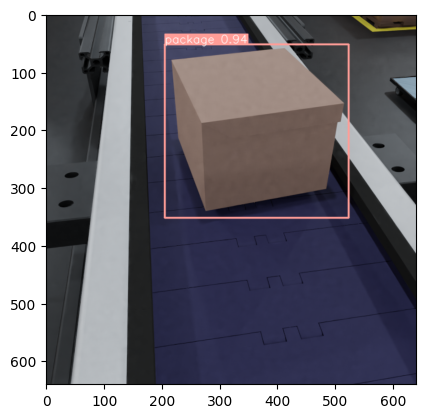

[
  {
    "name": "package",
    "class": 1,
    "confidence": 0.939598023891449,
    "box": {
      "x1": 205.0914306640625,
      "y1": 52.09014892578125,
      "x2": 523.1130981445312,
      "y2": 352.80157470703125
    }
  }
]
[205.0914306640625, 52.09014892578125, 523.1130981445312, 352.80157470703125]
Ultralytics YOLOv8.1.24 üöÄ Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

0: 1024x1024 82.8ms
Speed: 0.0ms preprocess, 82.8ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to runs/segment/predict13


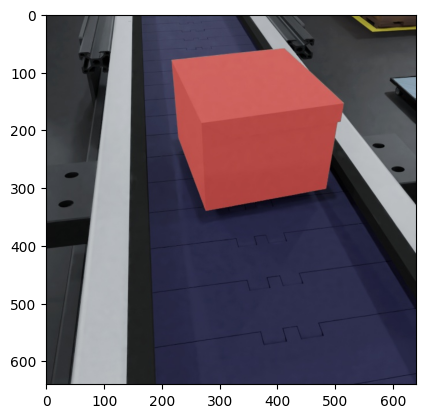

In [ ]:
result = detection()
show_image_after_ultralytics(result)

clean_memory_for_gpu()

bbox = get_bbox_from_result(result_to_json(result))
result = segmentation_bboxes(result[0].orig_img, bbox)
show_image_after_ultralytics(result)



In [ ]:
clean_memory_for_gpu()

segcrop0.png —Å–æ—Ö—Ä–∞–Ω–µ–Ω–æ –Ω–∞ –¥–∏—Å–∫


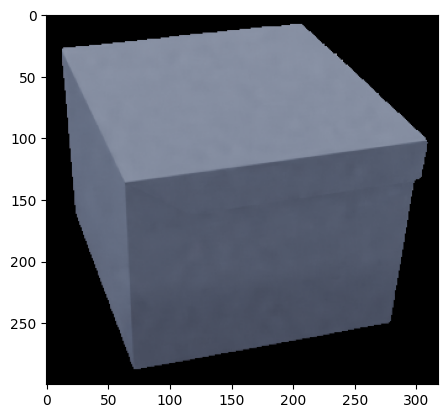

Ultralytics YOLOv8.1.24 üöÄ Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 4202.0ms
Speed: 0.1ms preprocess, 4202.0ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to runs/segment/predict15


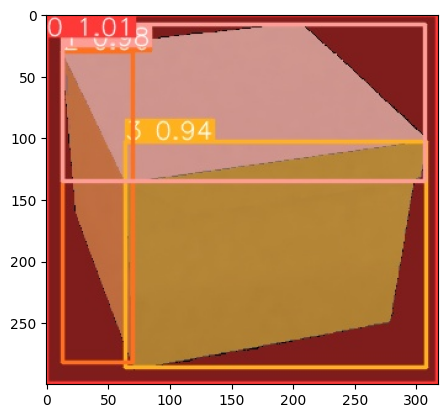

In [ ]:

result_side = segmentation_of_the_side(result, crop = True, bgcolor = 'black')
show_image_after_ultralytics(result_side)


221 221
207 207
217 217


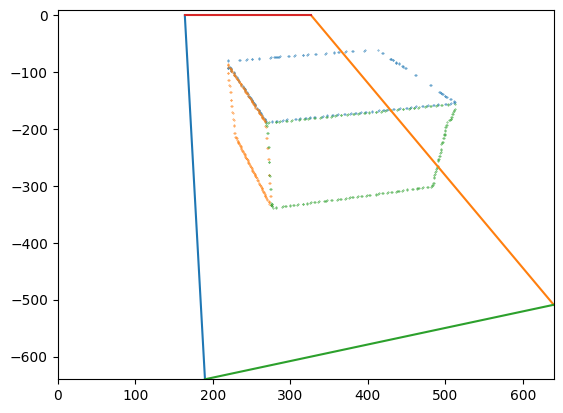

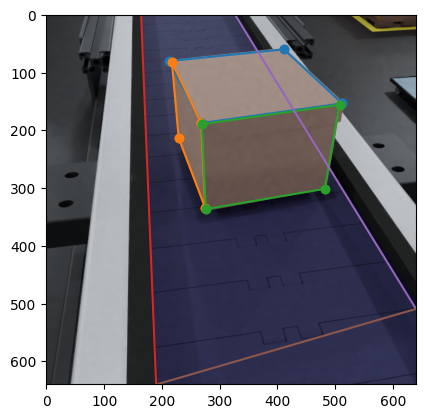

In [ ]:
point_cloud = get_xy_edges(result_side, bbox)#TODO bbox –µ—Å–ª–∏ –∫—Ä–æ–ø –ø–µ—Ä–µ–¥–∞–≤–∞—Ç—å –Ω–æ—Ä–º–∞—å–Ω—ã–π bbox —Å–¥–µ–ª–∞—Ç—å –ø—Ä–æ–≤–µ—Ä–∫—É
draw_point_cloud_edges(point_cloud)# TODO: –ø–µ—Ä–µ–¥–∞—Ç—å —Ä–∞–∑–º–µ—Ä—ã –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏—è –∞—Ä–≥—É–º–µ–Ω—Ç–æ–º


line_strings_all = approximate_point_cloud(point_cloud, size = [640,640])
draw_edges(line_strings_all, size = [640,640])

In [ ]:
clean_memory_for_gpu()

In [ ]:
print(line_strings_all)
# –§–æ—Ä–º–∏—Ä—É–µ–º —Å–ª–æ–≤–∞—Ä—å –≥—Ä–∞–Ω–µ–π c –∫–æ–æ—Ä–¥–∏–Ω–∞—Ç–∞–º–∏
sides_dict = {"sides":[]}
for i, side in enumerate(line_strings_all):
  edge_dict = {"edges":[]}
  for j, edge in enumerate(side):
    edge_dict[f"edges"].append({f"line": {'xy': [[edge.xy[0][0], edge.xy[1][0]], [edge.xy[0][1], edge.xy[1][1]]],\
                                          "centoroid": {'xy' : [edge.centroid.xy[0][0],edge.centroid.xy[1][0]]}}})
  sides_dict[f"sides"].append(edge_dict)

# –§–æ—Ä–º–∏—Ä—É–µ–º —Å–ª–æ–≤–∞—Ä—å –≥—Ä–∞–Ω–µ–π c –Ω–æ—Ä–º–∞–ª—å–Ω—ã–º–∏


# –¥–æ–±–∞–≤–ª—è–µ–º –Ω–∞ –±—É–¥—É—â–µ–µ —Å–ª–æ–≤–∞—Ä—å —Ü–µ–Ω—Ç—Ä—Ä–æ–∏–¥–æ–≤ –≥—Ä–∞–Ω–∏
sides_dict

[[<LINESTRING (411.406 -59.524, 212.08 -79.909)>, <LINESTRING (212.08 -79.909, 269.091 -187.09)>, <LINESTRING (269.091 -187.09, 512.091 -153.09)>, <LINESTRING (512.091 -153.09, 411.406 -59.524)>], [<LINESTRING (217.337 -81.438, 229.091 -213.09)>, <LINESTRING (229.091 -213.09, 275.091 -334.09)>, <LINESTRING (275.091 -334.09, 268.091 -187.09)>, <LINESTRING (268.091 -187.09, 217.337 -81.438)>], [<LINESTRING (507.617 -155.595, 269.091 -189.09)>, <LINESTRING (269.091 -189.09, 276.091 -336.09)>, <LINESTRING (276.091 -336.09, 482.091 -301.09)>, <LINESTRING (482.091 -301.09, 507.617 -155.595)>]]


{'sides': [{'edges': [{'line': {'xy': [[411.40599614753864,
        -59.52388654678937],
       [212.08042401421156, -79.90945642406146]],
      'centoroid': {'xy': [311.7432100808751, -69.71667148542542]}}},
    {'line': {'xy': [[212.08042401421156, -79.90945642406146],
       [269.0914306640625, -187.09014892578125]],
      'centoroid': {'xy': [240.58592733913704, -133.49980267492134]}}},
    {'line': {'xy': [[269.0914306640625, -187.09014892578125],
       [512.0914306640625, -153.09014892578125]],
      'centoroid': {'xy': [390.5914306640625, -170.09014892578125]}}},
    {'line': {'xy': [[512.0914306640625, -153.09014892578125],
       [411.40599614753864, -59.52388654678937]],
      'centoroid': {'xy': [461.7487134058006, -106.3070177362853]}}}]},
  {'edges': [{'line': {'xy': [[217.33673057453697, -81.43750792309548],
       [229.0914306640625, -213.09014892578125]],
      'centoroid': {'xy': [223.21408061929975, -147.26382842443837]}}},
    {'line': {'xy': [[229.0914306640625, -2

In [ ]:
{'sides': [{'edges': [{'line': {'xy': [[411.40599614753864,
        -59.52388654678937],
       [212.08042401421156, -79.90945642406146]],
      'centoroid': {'xy': [311.7432100808751, -69.71667148542542]}}},
    {'line': {'xy': [[212.08042401421156, -79.90945642406146],
       [269.0914306640625, -187.09014892578125]],
      'centoroid': {'xy': [240.58592733913704, -133.49980267492134]}}},
    {'line': {'xy': [[269.0914306640625, -187.09014892578125],
       [512.0914306640625, -153.09014892578125]],
      'centoroid': {'xy': [390.5914306640625, -170.09014892578125]}}},
    {'line': {'xy': [[512.0914306640625, -153.09014892578125],
       [411.40599614753864, -59.52388654678937]],
      'centoroid': {'xy': [461.7487134058006, -106.3070177362853]}}}]},
  {'edges': [{'line': {'xy': [[217.33673057453697, -81.43750792309548],
       [229.0914306640625, -213.09014892578125]],
      'centoroid': {'xy': [223.21408061929975, -147.26382842443837]}}},
    {'line': {'xy': [[229.0914306640625, -213.09014892578125],
       [275.0914306640625, -334.09014892578125]],
      'centoroid': {'xy': [252.0914306640625, -273.59014892578125]}}},
    {'line': {'xy': [[275.0914306640625, -334.09014892578125],
       [268.0914306640625, -187.09014892578125]],
      'centoroid': {'xy': [271.5914306640625, -260.59014892578125]}}},
    {'line': {'xy': [[268.0914306640625, -187.09014892578125],
       [217.33673057453697, -81.43750792309548]],
      'centoroid': {'xy': [242.71408061929975, -134.26382842443837]}}}]},
  {'edges': [{'line': {'xy': [[507.6168803387659, -155.59508577997184],
       [269.0914306640625, -189.09014892578125]],
      'centoroid': {'xy': [388.3541555014142, -172.34261735287654]}}},
    {'line': {'xy': [[269.0914306640625, -189.09014892578125],
       [276.0914306640625, -336.09014892578125]],
      'centoroid': {'xy': [272.5914306640625, -262.59014892578125]}}},
    {'line': {'xy': [[276.0914306640625, -336.09014892578125],
       [482.0914306640625, -301.09014892578125]],
      'centoroid': {'xy': [379.0914306640625, -318.59014892578125]}}},
    {'line': {'xy': [[482.0914306640625, -301.09014892578125],
       [507.6168803387659, -155.59508577997184]],
      'centoroid': {'xy': [494.8541555014142, -228.34261735287652]}}}]}]}

In [ ]:
sides_dict['sides'][0]['edges'][0]['line']['xy']

[[411.40599614753864, -59.52388654678937],
 [212.08042401421156, -79.90945642406146]]

In [ ]:
centroids = []

for i in sides_dict['sides']:
  c = []
  for j in i['edges']:
    c.append(j['line']['centoroid']['xy'])
  centroids.append(c)
centroids

[[[311.7432100808751, -69.71667148542542],
  [240.58592733913704, -133.49980267492134],
  [390.5914306640625, -170.09014892578125],
  [461.7487134058006, -106.3070177362853]],
 [[223.21408061929975, -147.26382842443837],
  [252.0914306640625, -273.59014892578125],
  [271.5914306640625, -260.59014892578125],
  [242.71408061929975, -134.26382842443837]],
 [[388.3541555014142, -172.34261735287654],
  [272.5914306640625, -262.59014892578125],
  [379.0914306640625, -318.59014892578125],
  [494.8541555014142, -228.34261735287652]]]

AttributeError: 'dict' object has no attribute 'xy'

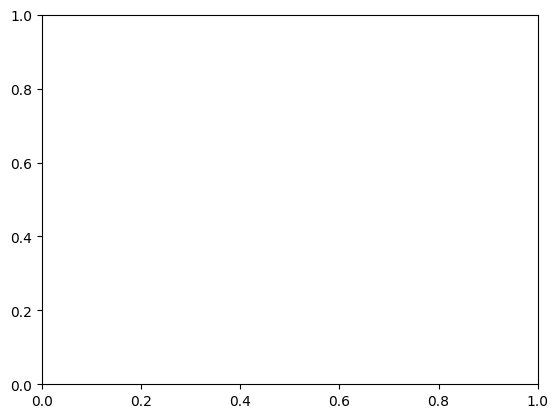

In [ ]:
# –ú–æ–∂–Ω–æ —Å—Ä–∞—Å—Ç–∏—Ç—å —Ä–µ–±—Ä–∞ –≤ –æ—Ç–¥–µ–ª—å–Ω–æ–º –∫–ª–∞—Å—Å–µ –ø–æ –º–∏–Ω–∏–º–∞–ª—å–Ω–æ–º—É –æ—Ç–∫–ª–æ–Ω–µ–Ω–∏—é


In [ ]:
centroids_dict

{0: {0: <POINT (311.743 -69.717)>,
  1: <POINT (240.586 -133.5)>,
  2: <POINT (390.591 -170.09)>,
  3: <POINT (461.749 -106.307)>},
 1: {0: <POINT (223.214 -147.264)>,
  1: <POINT (252.091 -273.59)>,
  2: <POINT (271.591 -260.59)>,
  3: <POINT (242.714 -134.264)>},
 2: {0: <POINT (388.354 -172.343)>,
  1: <POINT (272.591 -262.59)>,
  2: <POINT (379.091 -318.59)>,
  3: <POINT (494.854 -228.343)>}}

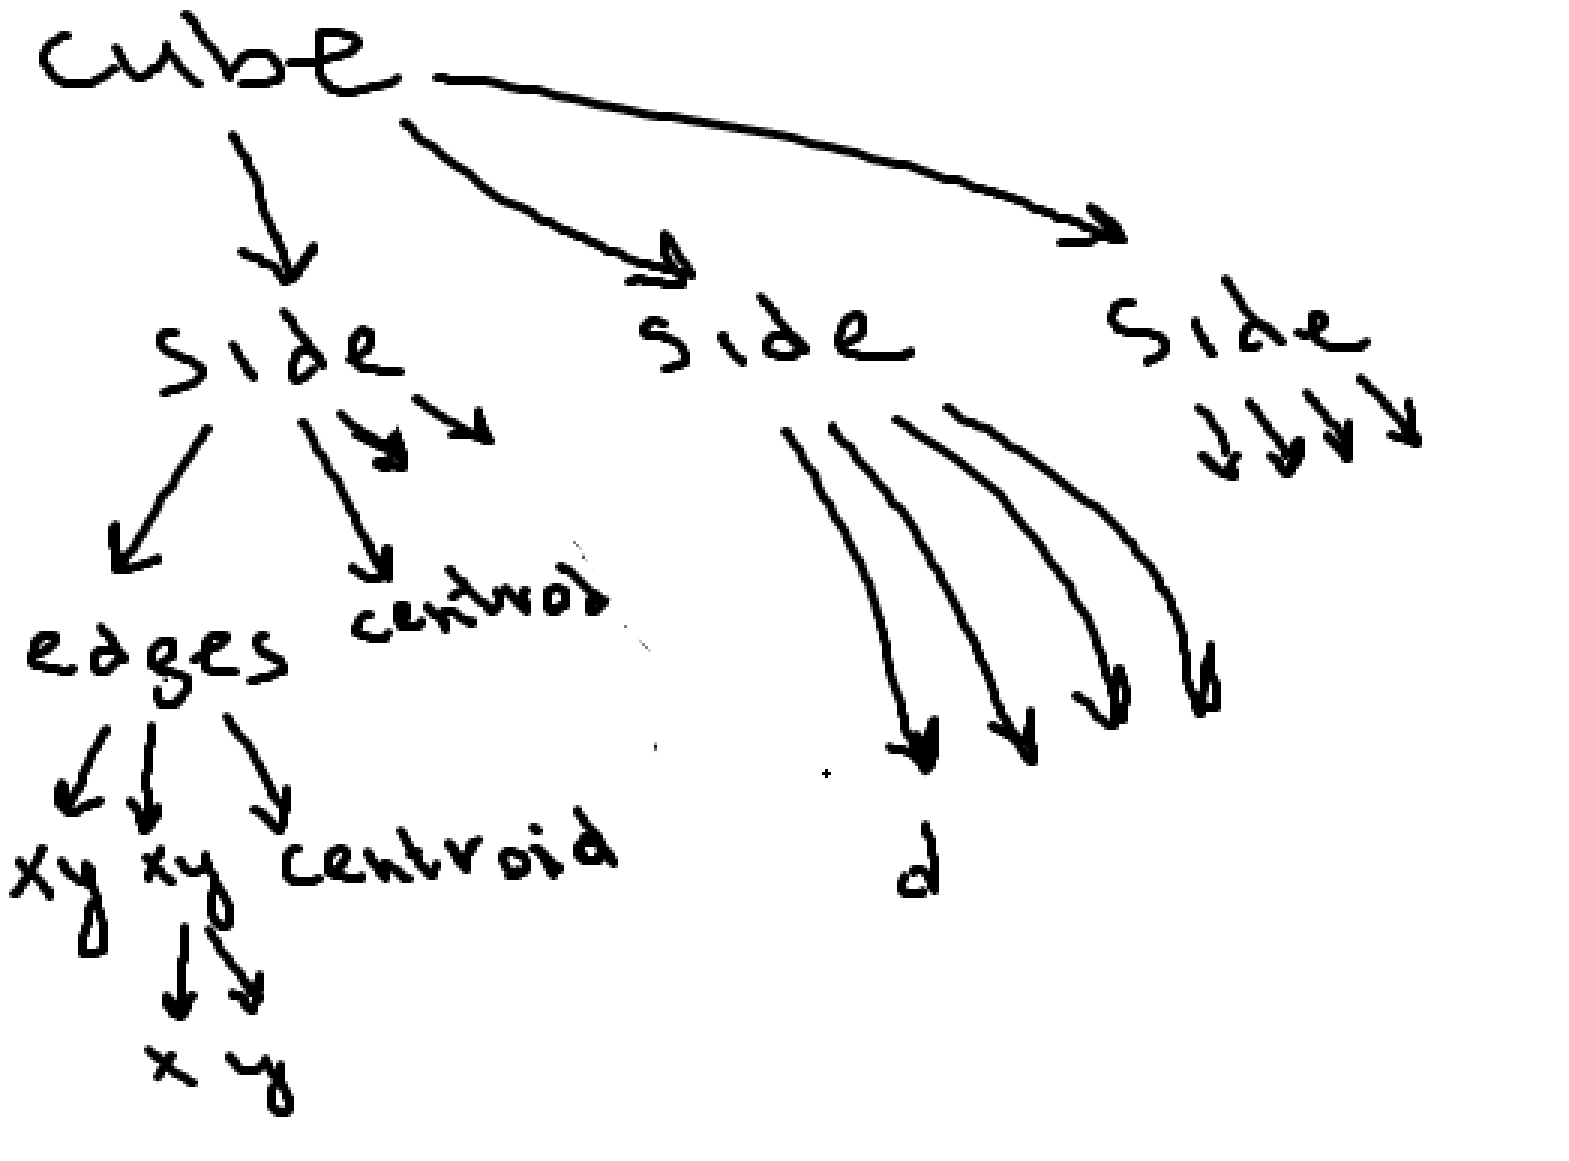

In [ ]:
for i in centroids_dict:
  print(i)

# print(centroids_dict[0][0].xy[1][0])

# min_y_centroid = centroids_dict[0][0].xy[1][0]
# min_y_centroid_xy = []
# for i, side in enumerate(line_strings_all):
#   for j, edge in enumerate(side):
#     if edge.xy[1][0] < min_y_centroid:
#       min_y_centroid = edge.xy[1][0]



0
1
2
-69.71667148542542
